In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Wed Feb 14 15:41:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              N/A /  20W |      0MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
num_heads = 5
equation_name = "duffing"

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (49, 50)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)

# create the A matrix associated with the ODE
def get_A(alpha):
    return torch.tensor([[0., -1.], [0.1, alpha]], device=dev).double() 
A_list = [get_A(i)for i in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[1.5, 2.5], y_bound=[0, 0]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
#IC_list = [random_IC() for i in range(num_heads)]
IC_list = [torch.tensor([[1.], [0.5]], device=dev).double() for _ in range(num_heads)]

force_list = [
    lambda t: torch.cat([torch.zeros(len(t), device=dev).unsqueeze(1), torch.cos(t).unsqueeze(1)], dim=1).double()
    if not isinstance(t, (float, int))
    else np.array([0, np.cos(t)]).T
    for _ in range(num_heads)
]

In [51]:
x_range = [0, 5]
activation = "silu"
hid_lay = list(np.array([128, 128, 256, 512]))
num_equations = 2
iterations = 10000


# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force(t)[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

#numerical_sol_fct = None

In [52]:
sample_size = 200
lr = 1e-4
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr,
                                                     A_list=A_list, v_list=IC_list, force=force_list,
                                                     hid_lay=hid_lay, activation=activation,
                                                     num_equations=num_equations, num_heads=num_heads,
                                                     sample_size = sample_size, decay=decay, dev=dev, verbose=verbose,
                                                     true_functs=None, save=False)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iterations 0, L_total = 3.414901391080244, L_ODE = 2.902016886331503, L_IC = 0.5128845047487414
Iterations 100, L_total = 0.15492501650135201, L_ODE = 0.031185645557981267, L_IC = 0.12373937094337076
Iterations 200, L_total = 0.1339476364730512, L_ODE = 0.016453269847315894, L_IC = 0.11749436662573529
Iterations 300, L_total = 0.12505556593976916, L_ODE = 0.009778311439449633, L_IC = 0.11527725450031952
Iterations 400, L_total = 0.1196976039785155, L_ODE = 0.004494097235427944, L_IC = 0.11520350674308756
Iterations 500, L_total = 0.11716632565196344, L_ODE = 0.0033136240340939753, L_IC = 0.11385270161786946
Iterations 600, L_total = 0.1160804236035782, L_ODE = 0.003219498920478783, L_IC = 0.11286092468309943
Iterations 700, L_total = 0.11512278675049582, L_ODE = 0.0022745805237656394, L_IC = 0.11284820622673018
Iterations 800, L_total = 0.11620839491543891, L_ODE = 0.0029265164600784767, L_IC = 0.11328187845536043
Iterations 900, L_total = 0.11554366920580784, L_ODE = 0.003254623824357

In [53]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force(t)[0] - A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[1] - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

In [54]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['L_total'],
                           loss_label='Total Loss ($L_D$)', device=dev)
plot_head_loss(loss_hist["head"], alpha_list)

TypeError: plot_loss_and_all_solution() got an unexpected keyword argument 'loss_label'

In [108]:
model_name = "base_model"
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/duffing/history_base_model_1311529.json


# Train on the non linear function

In [4]:
from src.train import run_model_non_linear

In [5]:
num_heads = 5
equation_name = "duffing"

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (1, 5)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)
alpha_list = [2, 3, 4, 5, 6]
beta = 0.5

def equation(t, y, alpha, beta=beta):
    if isinstance(y, torch.Tensor):
      yp = torch.zeros_like(y)
      force = torch.cos(t)
    elif isinstance(y, np.ndarray):
      yp = np.zeros_like(y)
      force = np.cos(t)
    yp[..., 0] = y[..., 1]
    yp[..., 1] = -0.1*y[..., 0] - alpha*y[..., 1] - beta*y[..., 0]**3 + force
    return yp

equation_list = [lambda t, y, Alpha=alpha: equation(t, y, Alpha) for alpha in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[1.5, 2.5], y_bound=[0, 0]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
#IC_list = [random_IC() for i in range(num_heads)]
IC_list = [torch.tensor([[1.], [0.5]], device=dev).double() for _ in range(num_heads)]

In [6]:
numerical_sol_fct = lambda x, v, alpha, beta: (solve_ivp(equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(alpha, beta), t_eval=x.squeeze(), method="Radau").y.T)
numerical_sol_list = [lambda x, IC=ic.detach().cpu().numpy(), Alpha=alpha, beta=beta: numerical_sol_fct(x, IC, Alpha, beta) for ic, alpha in zip(IC_list, alpha_list)]

In [12]:
x_range = [0, 5]
activation = "silu"
hid_lay = list(np.array([128, 128, 256, 512]))
reparametrization=True
num_equations = 2
iterations = 10000

In [13]:
sample_size = 200
lr = 1e-4
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_non_linear(iterations=iterations, x_range=x_range, lr=lr,
                                                            equation_list=equation_list, v_list=IC_list,
                                                            hid_lay=hid_lay, activation=activation,
                                                            num_equations=num_equations, num_heads=num_heads,
                                                            sample_size = sample_size, decay=decay, dev=dev, verbose=verbose,
                                                            true_functs=None, reparametrization=reparametrization)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iterations 0, L_total = 0.29593266052651346, L_ODE = 0.29593266052651346, L_IC = 1.232595164407831e-33
Iterations 100, L_total = 0.1400667564370286, L_ODE = 0.1400667564370286, L_IC = 0.0
Iterations 200, L_total = 0.023524866400097325, L_ODE = 0.023524866400097325, L_IC = 6.162975822039155e-34
Iterations 300, L_total = 0.020844695355778712, L_ODE = 0.020844695355778712, L_IC = 3.0814879110195775e-34
Iterations 400, L_total = 0.013206369115915618, L_ODE = 0.013206369115915618, L_IC = 6.162975822039155e-34
Iterations 500, L_total = 0.011155698182163167, L_ODE = 0.011155698182163167, L_IC = 3.0814879110195775e-34
Iterations 600, L_total = 0.003573233969856585, L_ODE = 0.003573233969856585, L_IC = 0.0
Iterations 700, L_total = 0.002815241477554257, L_ODE = 0.002815241477554257, L_IC = 0.0
Iterations 800, L_total = 0.0015903977328185486, L_ODE = 0.0015903977328185486, L_IC = 3.0814879110195775e-34
Iterations 900, L_total = 0.0008266247537451453, L_ODE = 0.0008266247537451453, L_IC = 3.08148

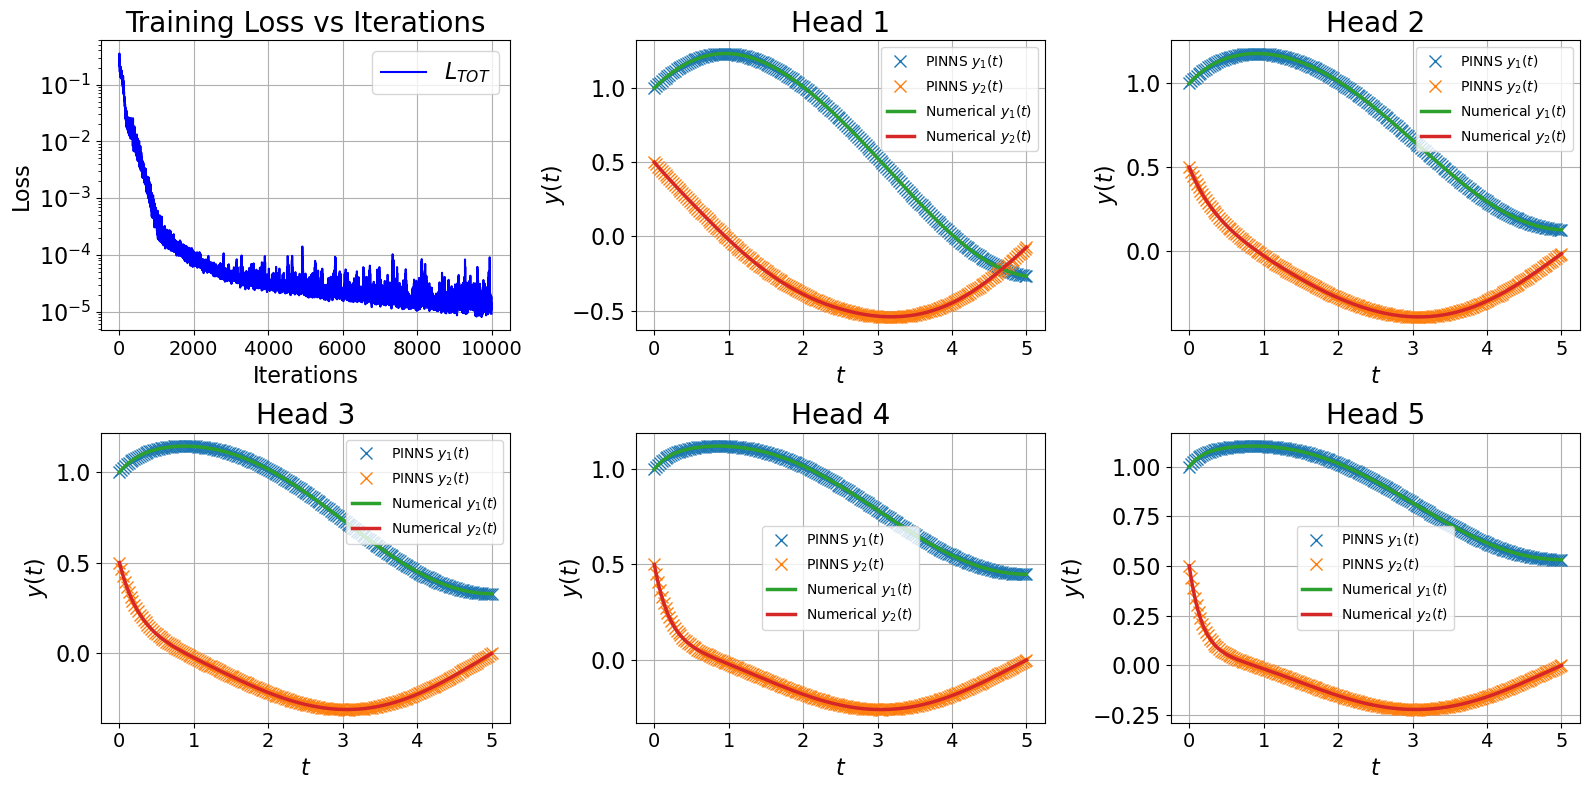

In [15]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_list,
                           trained_model=trained_model, v_list=IC_list,
                           A_list=None, force=None, train_losses=loss_hist,
                           device=dev, equation_list=equation_list, reparametrization=reparametrization)

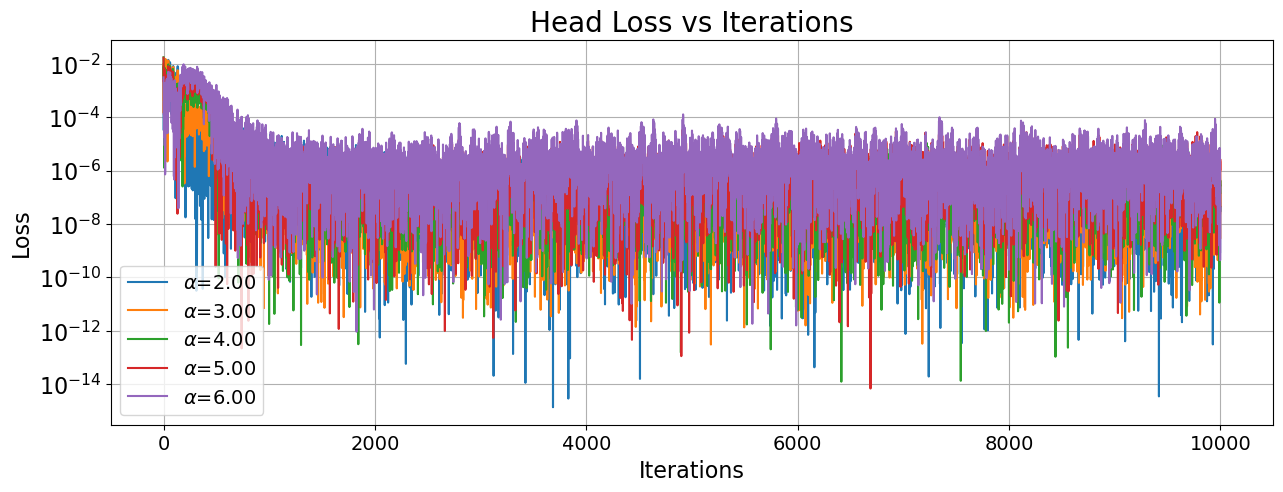

In [16]:
plot_head_loss(loss_hist["head"], alpha_list)

In [17]:
model_name = "nonlinear_repara"
A_list=[torch.tensor([np.nan])]
force_list = [torch.tensor([np.nan])]
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/duffing/history_nonlinear_repara_2141608.json


# Extract H and fine tuned the last layer

In [22]:
from collections import defaultdict
import time
from tqdm.auto import trange
import torch.nn as nn

from src.model import BuildNetworkNew
from src.loss import calc_loss_nonlinear


def transfer_learning(iterations, x_range, N, equation_transfer, IC, num_equations,
                      dev, hid_lay, activation, pretrained_model, lr, decay=True,
                      optimizer_name="SGD", milestones=[], gamma=0.1,
                      reparametrization=False, tqdm_bool=False):

    # build the neural net model
    model = BuildNetworkNew(1, hid_lay, num_equations, 1, activation).to(dev, dtype=torch.double)
    for i, (pretrained_layer, new_layer) in enumerate(zip(pretrained_model.hidden_layers, model.hidden_layers)):
        if isinstance(pretrained_layer, nn.Linear) and isinstance(new_layer, nn.Linear):
            # Assuming it's a linear layer, you might need to adjust for other layer types
            new_layer.weight.data.copy_(pretrained_layer.weight.data)
            new_layer.bias.data.copy_(pretrained_layer.bias.data)
            for param in new_layer.parameters():
                param.requires_grad = False  # Freeze the layer
    model.multi_head_output[0].bias = None
    
    # set-up the optimizer
    # if optimizer_name=="LBFGS":
    #     wait = 10
    #     switch_sgd = lambda list: len(list) >= wait and all(v == list[-wait] for v in list[-wait:])
    #     optimizer = torch.optim.LBFGS(model.parameters(), history_size=20, max_iter=1,
    #                                   line_search_fn="strong_wolfe", lr=lr)
    #elif optimizer_name=="SGD":
    if optimizer_name=="SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name=="Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    # store loss and mse values
    loss_history = defaultdict(list)

    start_time = time.time()

    # global curr_loss
    # training loop
    for i in trange(iterations) if tqdm_bool else range(iterations):

        rng = np.random.default_rng()
        x = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
        x = x[rng.choice(range(0, len(x)), size=N, replace=False)]
        x = x.reshape(-1, 1)
        x, _ = x.sort(dim=0)
        
        # def closure():
        #     global curr_loss
        #     L, curr_loss = calc_transfer_loss_non_linear(X_grid.unsqueeze(1), equation_transfer, v, model, reparametrization, device=dev)
        #     return L

        #if optimizer_name!="LBFGS":
        curr_loss = calc_loss_nonlinear(x, [equation_transfer], [IC], model, numerical_solution=None, t_eval=None, device=dev)

    #     # update weights and reset the gradients
    #     if optimizer_name=="LBFGS":
    #         optimizer.step(closure)
    #     else:
    #         optimizer.step()
    #   scheduler.step()

        if (i % 100 == 0):
            info_loss = f"Iterations {i}"
            for k, v in curr_loss.items():
                if k != "head":
                    info_loss += f", {k} = {v}"
            print(info_loss)

        if torch.isnan(curr_loss["L_total"]).item():
            print(f"Training stop after {i} because of diverge loss. Setup: {optimizer_name}, {lr}, {reparametrization}")
            end_time = time.time()
            total_time = end_time - start_time
            return loss_history, model, total_time

        # store individual loss terms for plotting
        loss_history['L_IC'].append(curr_loss['L_IC'].detach().item())
        loss_history['L_ODE'].append(curr_loss['L_ODE'].detach().item())
        loss_history['L_total'].append(curr_loss['L_total'].detach().item())

        # backward: backpropagation
        curr_loss['L_total'].backward()

        # if decay:
        #     gamma = 0.98  # Adjust the decay factor accordingly
        #     every = 100  # Adjust the decay interval accordingly
        #     for param in model.parameters():
        #         param.grad *= (gamma**((i + 1) / every))

        optimizer.step()
        optimizer.zero_grad()

    #     if not reparametrization:
    #         loss_history['L_0'].append(curr_loss["L_0"].detach().item())
    #     if (optimizer_name=="LBFGS"):
    #         if(switch_sgd(loss_history['Ltotal_losses'])):
    #             optimizer_name = "SGD"
    #             optimizer = torch.optim.SGD(model.parameters(), lr=optimizer.param_groups[0]['lr']*0.1, momentum=0.9)
    #             if tqdm_bool:
    #                 print(f"Switch to SGD at iteration {i} with lr={optimizer.param_groups[0]['lr']}")

    end_time = time.time()
    total_time = end_time - start_time
    return loss_history, model, total_time

In [23]:
alpha_transfer = 5
lr = 0.0001


In [42]:
iterations=10000
N=200
equation_transfer = lambda t, y, Alpha=alpha_transfer: equation(t, y, Alpha)
IC = IC_list[0]
loss_transfer, model_transfer, time_transfer = transfer_learning(iterations=iterations, x_range=x_range, N=N,
                                                                 equation_transfer=equation_transfer, IC=IC,
                                                                 num_equations=num_equations, dev=dev, hid_lay=hid_lay,
                                                                 activation=activation, pretrained_model=trained_model,
                                                                 lr=lr, optimizer_name="SGD", milestones=[], gamma=0.1,
                                                                 reparametrization=False, tqdm_bool=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iterations 0, L_total = 0.9237432027602399, L_ODE = 0.4786733416508556, L_IC = 0.44506986110938435
Iterations 100, L_total = 0.028690921542120294, L_ODE = 0.00987859134599753, L_IC = 0.018812330196122766
Iterations 200, L_total = 0.022703989380169584, L_ODE = 0.011271484988835012, L_IC = 0.011432504391334572
Iterations 300, L_total = 0.017152447592788892, L_ODE = 0.008255235749672298, L_IC = 0.008897211843116594
Iterations 400, L_total = 0.017896506542878863, L_ODE = 0.010964685601937718, L_IC = 0.006931820940941145
Iterations 500, L_total = 0.014108873462808293, L_ODE = 0.007996334407080488, L_IC = 0.0061125390557278045
Iterations 600, L_total = 0.012997984012896716, L_ODE = 0.007814413867470503, L_IC = 0.005183570145426213
Iterations 700, L_total = 0.010140026945900448, L_ODE = 0.005819386509290579, L_IC = 0.00432064043660987
Iterations 800, L_total = 0.009436466398456432, L_ODE = 0.005683439007956309, L_IC = 0.0037530273905001235
Iterations 900, L_total = 0.008315213428925525, L_ODE

mean 0.005972246178339561
max 0.010510969609072829
mean 0.0019316922541613001
max 0.006187847967819392


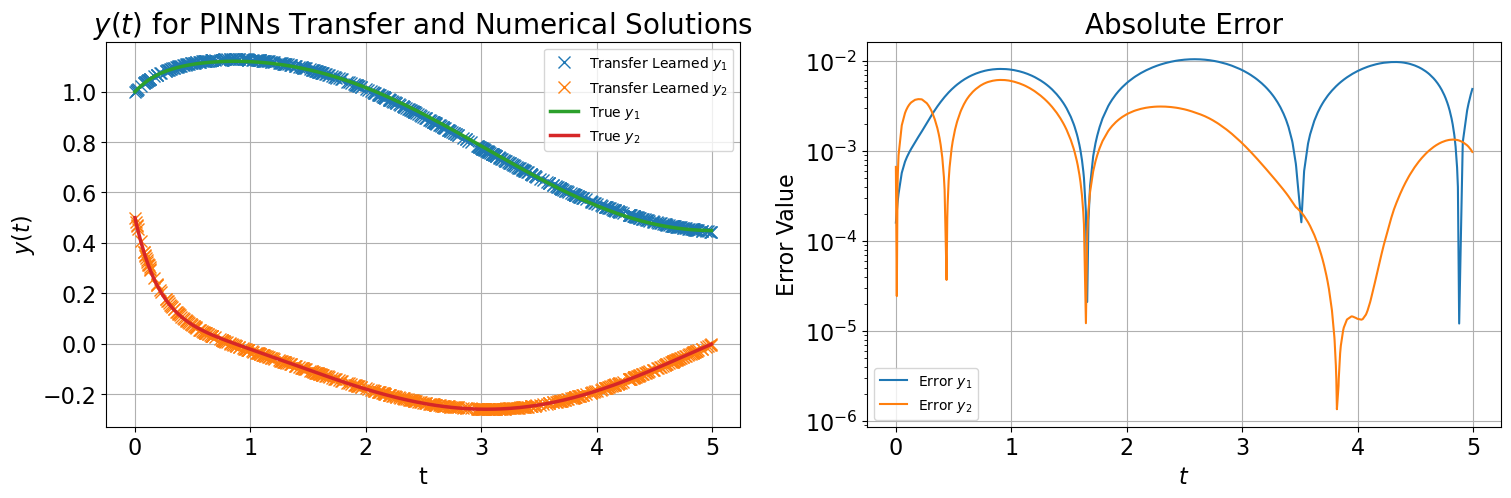

In [43]:
from src.utils_plot import plot_transfer_learned_and_analytical

rng = np.random.default_rng()
t_eval = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
t_eval = t_eval[np.concatenate(([0], rng.choice(range(1, len(t_eval)), size=512 - 1, replace=False)))]
t_eval = t_eval.reshape(-1, 1)
t_eval, _ = t_eval.sort(dim=0)

true_funct = lambda x: numerical_sol_fct(x, v=IC.detach().cpu().numpy(), alpha=alpha_transfer, beta=beta)
plot_transfer_learned_and_analytical(H=None, W_out=model_transfer, t_eval=t_eval, v=IC, A=None, force=None,
                                     num_equations=num_equations, true_funct=true_funct)